### Setup

In [2]:
import os
import copy
from IPython import display
import torch

from gamma.flows import (
    make_conditional_flow,
    save_model,
    load_model,
)
from gamma.td.distributions import BootstrapTarget
from gamma.td.structs import (
    ReplayPool,
    Policy,
)
from gamma.td.utils import (
    soft_update_from_to,
    format_batch,
)
from gamma.utils import (
    mkdir,
    set_device,
)

from gamma.visualization import (
    make_prob_fn,
    display_video,
)
from gamma.visualization.pendulum import (
    visualize,
    visualize_values,
)

%load_ext autoreload
%autoreload 2

### Hyperparameters

In [3]:
class Args:
    ## paths
    data_path = '../data/pools/pendulum.pkl'
    policy_path = '../data/policies/pendulum.pkl'
    save_path = '../logs/pendulum'
    
    load_epoch = None
    device = 'cuda:0'
    
    ## model
    hidden_dims = [256, 256, 256]
    sigma = 0.1
    
    ## training
    batch_size = 1024
    lr = 1e-4
    decay = 1e-5
    tau = 0.005
    discount = 0.99
    sample_discount = 0.9
    burnin_discount = 0.5
    
    n_burnin = 2000
    n_steps = 100000
    
    vis_freq = 100
    save_freq = 1000
    
args = Args()

mkdir(args.save_path)
set_device(args.device)

### Data

In [4]:
## load offline data and policy
dataset = ReplayPool(args.data_path)
policy = Policy(args.policy_path)

observation_dim = dataset['observations'].shape[1]
action_dim = dataset['actions'].shape[1]

/home/janner/utils/miniconda3/envs/gamma/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### Model

In [5]:
## like most single-step models, the gamma-model 
## is conditioned on a state and action
condition_dims = {
    's': observation_dim,
    'a': action_dim,
}

## initialize conditional spline flow
model = make_conditional_flow(observation_dim, args.hidden_dims, condition_dims)

## target model is analogous to a target Q-function
target_model = copy.deepcopy(model)

## bootstrapped target distribution is mixture of 
## single-step gaussian (with weight `1 - discount`)
## and target model (with weight `discount`)
bootstrap = BootstrapTarget(target_model, args.discount)

In [6]:
if args.load_epoch is not None:
    ## load model from disk and copy to target model
    load_model(args.save_path, args.load_epoch, model)
    soft_update_from_to(model, target_model, tau=1.)

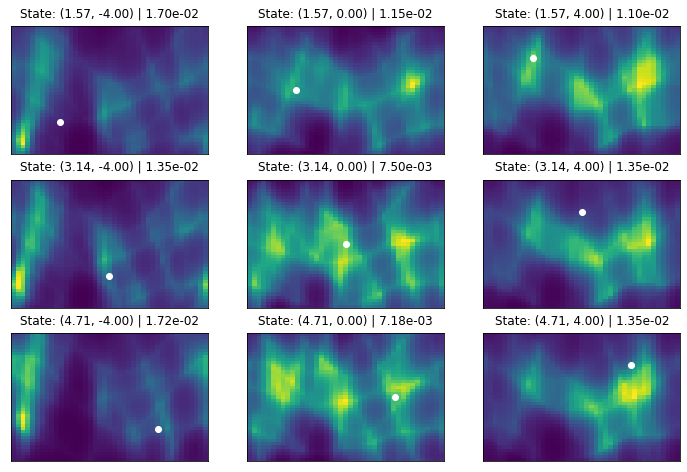

In [7]:
## visualize the randomly-initialized model
prob_fn = make_prob_fn(model, policy)
visualize(prob_fn)

### Training

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.decay)
criterion = torch.nn.MSELoss()

In [ ]:
images = []
for i in range(args.n_steps):
    
    if i < args.n_burnin and False:
        ## initialize model with a lower discount to speed up training
        bootstrap.update_discount(args.burnin_discount)
        sample_discount = args.burnin_discount
    else:
        bootstrap.update_discount(args.discount)
        sample_discount = args.sample_discount
    
    ## batch contains the usual Q-learning entries (s, a, s', r, t)
    batch = dataset.sample(args.batch_size)

    ## condition dicts contain keys (s, a)
    condition_dict, next_condition_dict = format_batch(batch, policy)

    ## update single-step distribution as N(s', σ)
    bootstrap.update_p(next_condition_dict['s'], sigma=args.sigma)
    
    ## sample from bootstrapped target distribution
    samples = bootstrap.sample(args.batch_size,
              condition_dict, next_condition_dict, discount=sample_discount)
    
    ## get log-prob of samples under both the target distribution and the model
    log_prob_target = bootstrap.log_prob(samples, condition_dict, next_condition_dict)
    log_prob_model = model.log_prob(samples, condition_dict)
    
    ## update model toward target distribution
    loss = criterion(log_prob_model, log_prob_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ## target model parameters are an exponentially-moving average of model parameters
    soft_update_from_to(model, target_model, args.tau)

    if i % args.save_freq == 0:
        save_model(args.save_path, i, model)

    if i % args.vis_freq == 0 and i > 0:
        display.clear_output(wait=True)
        
        print(f'Iteration {i} | Loss: {loss.item():.6f}\n')
        img = visualize(prob_fn, save_path=os.path.join(args.save_path, str(i)), itr=i)
        images.append(img)
        display_video(images)

Iteration 56700 | Loss: 0.023239



In [ ]:
## predict values with discretized grid over the state space
## (increase `n_steps` for finer grid but longer runtime)
visualize_values(prob_fn, n_steps=20)